To do the sunrise/sunset calculations you'll need to do:

```
conda install dateutil
conda install ephem
```

On windows, you can get an ncdump executable [here](http://www.unidata.ucar.edu/software/netcdf/docs/winbin.html)

In [33]:
!pwd

/home/wesley/atsc500/notebooks


In [34]:
import glob
from netCDF4 import Dataset
from dateutil.parser import parse
import datetime
import numpy as np
import matplotlib.dates as mdates

filelist=['cesar_nubiscope_cloudcover_la1_t10_v1.0_201407.nc',
          'cesar_nubiscope_cloudcover_la1_t10_v1.0_201412.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201407.nc',
          'cesar_surface_flux_lc1_t10_v1.0_201412.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201407.nc',
          'cesar_surface_meteo_lc1_t10_v1.0_201412.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201407.nc',
          'cesar_tower_meteo_lb1_t10_v1.1_201412.nc']

In [35]:
import urllib
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/cabauw/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)

The make_date function takes an open CESAR ncfile and turns the time
vector from hours past the start date into a python datetime object
in UTC.  It uses the dateutil parse function to turn the date_start_of_data
string into a date.

In [36]:
def make_date(ncfile):
    """
    ncfile:  open netCDF4 Dataset
    returns:
       numpy array of datetime objects
    """
    the_time=f.variables['time'][...]
    start_date=f.variables['product'].date_start_of_data
    start_date = parse(start_date)
    time_vec=[]
    for the_hour in the_time:
        time_vec.append(start_date + datetime.timedelta(hours=float(the_hour)))
    time_vec=np.array(time_vec)
    return time_vec


Loop through all the files and make a dictionary with keys determined
by the netcdf file attributes.  Initially the dictionary contains the
filename, start_date, lat, lon and start time.

In [37]:
all_files=glob.glob('cesar*.nc')
data_dict={}
for the_file in all_files:
    with Dataset(the_file,'r') as f:
        print (the_file)
        print ()
        print('     ', list(f.variables.keys()))
        print ()
        details=f.variables['iso_dataset']
        attributes=details.ncattrs()
        attr_dict={}
        for attr in attributes:
            attr_dict[attr]=getattr(details,attr)
        lon=attr_dict['westbound_longitude']
        lat=attr_dict['northbound_latitude']
        title=attr_dict['title'].split()
        the_time = make_date(f)
        #
        # turn a title like:
        #"CESAR surface fluxes validated and gap filled"
        # into the string: surface_fluxes
        #
        filetype='{}_{}'.format(*title[1:3])
        start_date=f.variables['product'].date_start_of_data
        start_date=parse(start_date)
        start_month=start_date.strftime('%Y%m')
    data_dict[filetype,start_month]=dict(name=the_file,start=start_date,lat=lat,lon=lon,
                                         time=the_time)
print(data_dict.keys())    

cesar_surface_meteo_lc1_t10_v1.0_201407.nc

      ['iso_dataset', 'product', 'station_details', 'time', 'date', 'valid_dates', 'time_bnds', 'P0', 'IP0', 'RAIN', 'IRAIN', 'SWD', 'ISWD', 'TA002', 'ITA002', 'Q002', 'IQ002', 'F010', 'IF010', 'D010', 'ID010', 'TD002', 'RH002']

cesar_surface_flux_lc1_t10_v1.0_201412.nc

      ['iso_dataset', 'product', 'station_details', 'time', 'date', 'valid_dates', 'time_bnds', 'UST', 'IUST', 'FC', 'IFC', 'H', 'IH', 'LE', 'ILE', 'G0', 'IG0', 'QN', 'IQN', 'LE2', 'ILE2']

cesar_nubiscope_cloudcover_la1_t10_v1.0_201407.nc

      ['iso_dataset', 'product', 'station_details', 'time', 'time_zenith', 'cldcover_total', 'cldcover_high', 'cldcover_middle', 'cldcover_low', 'obscuration_type', 'temp_blue_sky', 'temp_zero', 'surface_temp_west', 'surface_temp_east', 'temp_housing', 'rainflag', 'zenith_temp', 'zenith_height', 'valid_dates']

cesar_tower_meteo_lb1_t10_v1.1_201412.nc

      ['iso_dataset', 'product', 'station_details', 'time', 'date', 'valid_dates', 'tim

Now loop through the dictionary and add the flux and tower variables.
Each variable is a linear vector of measurements taken every 10 minutes, and
for tower variables, at 7 levels.

The numpy command:
var.reshape(-1,24,6,7)
takes the linear vector and folds it into either 28,29,30,31 days (depending on monty)
24 hours, 6 10 minute intervals, and 7 levels

That allows us to do an hourly average by saying:
var.mean(axis=2)  to average over the 6 10 minute measurements.

In [38]:
for the_key in data_dict.keys():
    if the_key[0] == 'tower_meteorological':
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            var_dict['z'] = f.variables['z'][...]
            for var in ['F','TA','TD','Q']:
                var_dict[var] = f.variables[var][...].reshape(-1,24,6,7)
    elif the_key[0] == 'surface_fluxes': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['H','UST','LE']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'meteorological_surface': 
        var_dict=data_dict[the_key]
        with Dataset(var_dict['name'],'r') as f:
            for var in ['P0']:
                var_dict[var] = f.variables[var][...]
    elif the_key[0] == 'scanning_radiometer':
        pass
    else:
        raise ValueError("didn't recognize {}".format(the_key[0]))

We'll need to know sunrise, sunset and solar noon to interpret our
data.  Here is how you find these with the 
[pyephem](http://stackoverflow.com/questions/2637293/calculating-dawn-and-sunset-times-using-pyephem) module

In [39]:
month=['201407','201412']
import ephem
for the_month in month:
    var='tower_meteorological'
    tower_dict=data_dict[var,the_month]
    start_time=tower_dict['time'][0]
    cabauw=ephem.Observer()
    cabauw.date=start_time
    cabauw.lon = tower_dict['lon']
    cabauw.lat = tower_dict['lat']
    sunrise=cabauw.next_rising(ephem.Sun())
    noon = cabauw.next_transit(ephem.Sun(),start=sunrise)
    sunset = cabauw.next_setting(ephem.Sun())
    print('sunrise is {} UTC'.format(sunrise))
    print('solar noon {} UTC'.format(noon))
    print('sunset is {} UTC'.format(sunset))

sunrise is 2014/7/1 03:24:19 UTC
solar noon 2014/7/1 11:44:09 UTC
sunset is 2014/7/1 20:03:38 UTC
sunrise is 2014/12/1 07:25:04 UTC
solar noon 2014/12/1 11:29:17 UTC
sunset is 2014/12/1 15:33:10 UTC


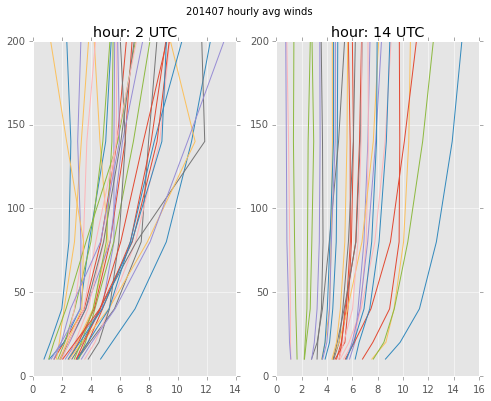

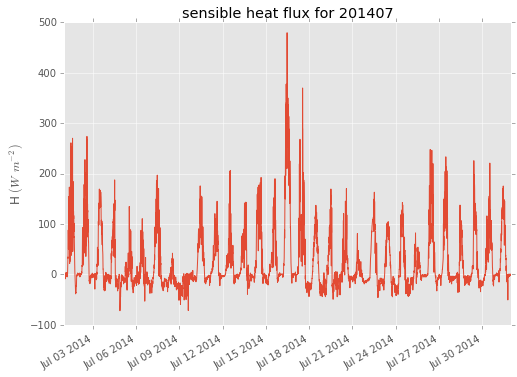

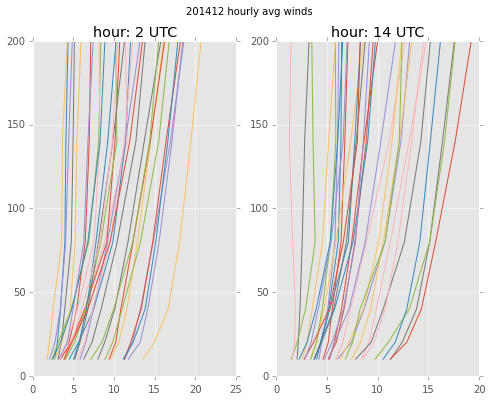

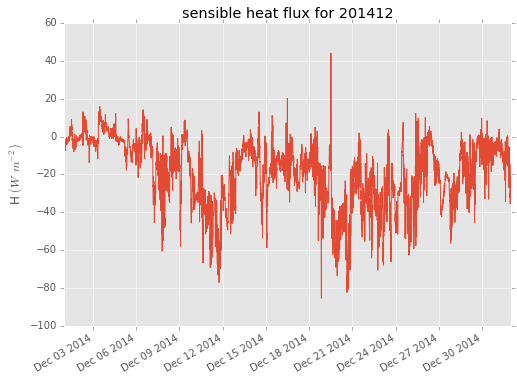

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.close('all')
    
var='tower_meteorological'
tower_dict=data_dict[var,the_month]
the_times=tower_dict['time'].reshape(-1,24,6)    


for the_month in month:
    var='tower_meteorological'
    tower_dict=data_dict[var,the_month]
    hourly_wind_avg=tower_dict['F'].mean(axis=2)
    z=tower_dict['z']
    
    hour=2
    fig,ax=plt.subplots(1,2,figsize=(8,6))
    ax[0].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[0].set(title='hour: {} UTC'.format(hour))
    hour=14
    ax[1].plot(hourly_wind_avg[:,hour,:].T,z)
    ax[1].set(title='hour: {} UTC'.format(hour))
    fig.suptitle('{} hourly avg winds'.format(the_month))

    #
    # date plotting tips at http://matplotlib.org/users/recipes.html
    #
    var='surface_fluxes'
    flux_dict=data_dict[var,the_month]

    fig,ax=plt.subplots(1,1,figsize=(8,6))
    fig.autofmt_xdate()
    ax.plot(flux_dict['time'],flux_dict['H'])
    title='sensible heat flux for {}'.format(the_month)
    ax.set(title=title,ylabel='H $(W\,m^{-2})$')
